In [64]:
%pip install tf_keras_vis

Note: you may need to restart the kernel to use updated packages.


# Create your dataset

1) Choose which classes you would like to add.

2) Create a dataset with your own photos

3) Separate your dataset into train and test subsets.

In [76]:
# --- Standard & scientific stack -------------------------------------------
import os, warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"   # 0=Défaut, 1=INFO, 2=WARNING, 3=ERROR
warnings.filterwarnings("ignore")

import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from PIL import Image

# --- TensorFlow / Keras -----------------------------------------------------
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import (
    Resizing, Rescaling,
    RandomFlip, RandomRotation, RandomZoom,
    RandomTranslation, RandomCrop,
    RandomBrightness, RandomContrast,
    GlobalAveragePooling2D, Dense, Dropout
)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy


# --- tf-keras-vis -----------------------------------------------------------
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

# --- Scikit-learn -----------------------------------------------------------
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold

In [66]:
def create_dataframe_from_directories(path):
    data = []

    for label_dir in os.listdir(path):
        if os.path.isfile(label_dir):
            continue

        label_path_path = os.path.join(path, label_dir)
        for file in os.listdir(label_path_path):
            data.append([os.path.join(label_path_path, file), label_dir])
        
    return pd.DataFrame(data, columns = ["path", "label"])

In [67]:
# If you're using Google Colab, you need to upload your data to Google Drive.
# Then, run the following code to mount your Google Drive and access your files in Colab.

#from google.colab import drive
#drive.mount('/content/drive')

In [68]:
# Configuration
dataset_path = "dataset"
batch_size = 32
img_size = (224, 224)
seed = 123

# Chargement du dataset brut
raw_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

raw_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

# Affichage des noms de classes détectées
class_names = raw_train_ds.class_names
print("Classes détectées :", class_names)

# Prétraitement MobileNetV2
train_ds = raw_train_ds.map(lambda x, y: (preprocess_input(x), y)).cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = raw_val_ds.map(lambda x, y: (preprocess_input(x), y)).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 300 files belonging to 5 classes.
Using 240 files for training.
Found 300 files belonging to 5 classes.
Using 60 files for validation.
Classes détectées : ['bieres', 'champagne', 'sans_alcool', 'spiritueux', 'vins']


**TODO**: Display some images of your dataset

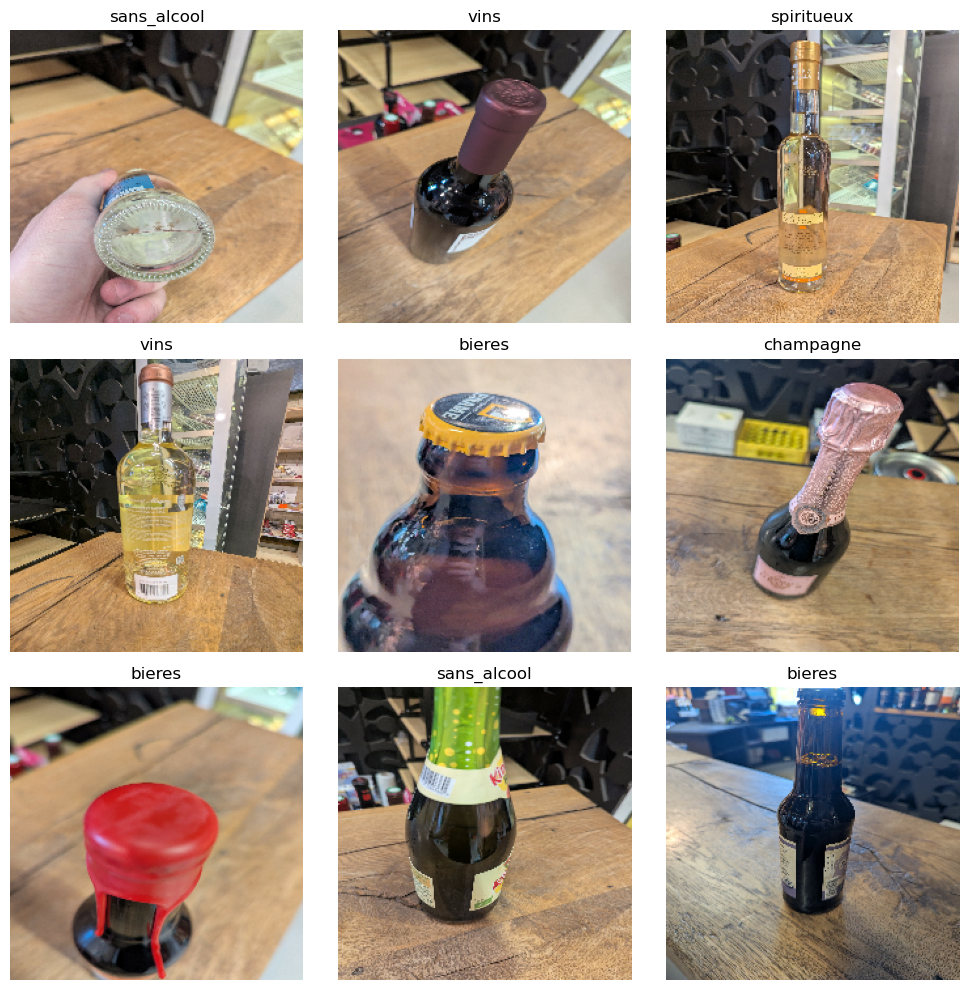

In [69]:
# Affichage de 9 images aléatoires avec leur étiquette
num_images = 9
image_batch, label_batch = next(iter(raw_train_ds))

plt.figure(figsize=(10, 10))
for i in range(num_images):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")
plt.tight_layout()
plt.show()

# Explore your dataset

**TODO**: count the number of examples per classes and plot an histogram of it

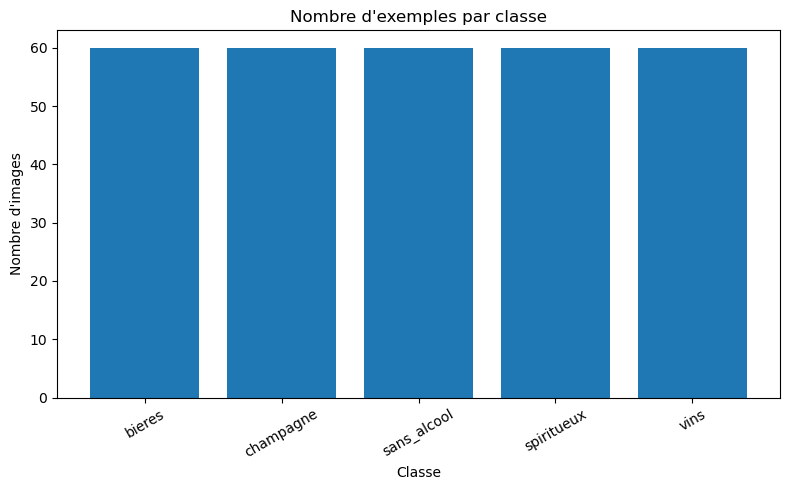

In [70]:
# Compter les images par classe dans le dossier dataset
class_counts = {}
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        class_counts[class_name] = len(os.listdir(class_dir))

# Affichage de l'histogramme
plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.title("Nombre d'exemples par classe")
plt.xlabel("Classe")
plt.ylabel("Nombre d'images")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# Preprocessing steps

In [71]:
IMG_HEIGHT = 224
IMG_WIDTH = 224

image_preprocesses = Sequential([
    Resizing(IMG_HEIGHT, IMG_WIDTH, crop_to_aspect_ratio=True),
    Rescaling(1. / 255)
])

image_augmentations = Sequential([
    # TODO: choose some image augmentations layers
    # see which keras layers you can use
    # The kind of layers you will want to use starts with "Random".
    # See the following page for more information on data augmentation :
    # https://www.tensorflow.org/tutorials/images/data_augmentation
    
    RandomFlip("horizontal"),      # retournement horizontal aléatoire
    RandomRotation(0.1),           # rotation aléatoire de ±10%
    RandomZoom(0.1),               # zoom in/out aléatoire
])

def open_image(path):
    with PIL.Image.open(path) as image:
        image = image.convert("RGB")  # Assure 3 canaux
        image_array = np.asarray(image)
        processed_image = image_preprocesses(image_array)
    return processed_image

def open_images(paths):
    return tf.stack([
        open_image(path) for path in paths
    ])

def augment_images(images):
    return image_augmentations(images)

**TODO**: plot examples of preprocessed and augmented images

In [72]:
IMG_HEIGHT = 224
IMG_WIDTH  = 224

image_preprocesses = Sequential([
    Resizing(IMG_HEIGHT, IMG_WIDTH, crop_to_aspect_ratio=True),
    Rescaling(1. / 255)
])

# Renommé en « data_augmentation » pour que get_model le trouve
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
])

def open_image(path):
    with Image.open(path) as image:
        image = image.convert("RGB")
        image_array = np.asarray(image)
        processed_image = image_preprocesses(image_array)
    return processed_image

def open_images(paths):
    return tf.stack([open_image(path) for path in paths])

def augment_images(images):
    return data_augmentation(images)

## Define model

In [73]:
def get_model(num_classes: int):
    base_model = tf.keras.applications.MobileNetV2(
        include_top=False,
        weights="imagenet",
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False          # feature-extraction par défaut

    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = data_augmentation(inputs)         # couche d’augmentation
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
    x = base_model(x, training=False)     # frozen
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # --- Régularisation  -----------------------------------------------------
    x = tf.keras.layers.Dropout(0.3)(x)   # ← nouveau : dropout 30 %

    x = tf.keras.layers.Dense(128, activation="relu")(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

    return tf.keras.Model(inputs, outputs, name="mobilenetv2_transfer")

In [74]:
get_model(num_classes=len(class_names)).summary()

Model: "mobilenetv2_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_25 (Sequential)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide_5 (TrueDivide)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract_5 (Subtract)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Model training

**TODO**: cross-validate your model, you can base yourself on the code from the first part of this practical work

**NOTE**: you shouldn't augment validations images. What we want to evaluate is the performances on "real" images, not on images that are augmented and change all the time 

In [75]:
# ------------------------------------------------------------------
# 0. Préparation des folds (chemins, labels, split stratifié)

num_folds = 5
train_df  = create_dataframe_from_directories(dataset_path)

paths  = train_df["path"].values
labels = train_df["label"].astype("category").cat.codes.values   # labels numériques

skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)

# ------------------------------------------------------------------
# Fonction utilitaire : lit un fichier image et applique le pré-traitement
def path_to_tensor(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = img / 255.0                              # normalisation [0,1]
    return img, label

# ------------------------------------------------------------------
# 1. (Re)définition d'un bloc d'augmentations "fortes"
def get_augmentations():
    return tf.keras.Sequential([
        RandomFlip("horizontal_and_vertical"),
        RandomRotation(0.25),
        RandomZoom(0.20),
        RandomTranslation(0.10, 0.10),
        RandomCrop(224, 224),
        RandomBrightness(0.2),
        RandomContrast(0.2),
    ], name="data_augmentation_strong")

# ------------------------------------------------------------------
results = []
for fold, (train_idx, val_idx) in enumerate(skf.split(paths, labels), 1):
    print(f"\n===== FOLD {fold}/{num_folds} =====")

    aug_layer = get_augmentations()          # ← recréé à chaque fold

    train_ds = (
        tf.data.Dataset.from_tensor_slices((paths[train_idx], labels[train_idx]))
          .shuffle(len(train_idx))
          .map(path_to_tensor, num_parallel_calls=tf.data.AUTOTUNE)   # <- OK
          .batch(batch_size)
          .map(lambda x, y: (aug_layer(x, training=True), y),
               num_parallel_calls=tf.data.AUTOTUNE)
          .prefetch(tf.data.AUTOTUNE)
    )

    val_ds = (
        tf.data.Dataset.from_tensor_slices((paths[val_idx], labels[val_idx]))
          .map(path_to_tensor, num_parallel_calls=tf.data.AUTOTUNE)
          .batch(batch_size)
          .prefetch(tf.data.AUTOTUNE)
    )

    model = get_model(num_classes=len(class_names))

    # — compilation avant l’entraînement —
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=SparseCategoricalCrossentropy(),     # logits déjà softmax
        metrics=['accuracy']
    )

    es = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

    history = model.fit(
        train_ds,
        epochs=30,
        validation_data=val_ds,
        callbacks=[es],
        verbose=2
    )

    val_loss, val_acc = model.evaluate(val_ds, verbose=0)
    print(f"✔️  Fold {fold} – val_acc : {val_acc:.3f}")
    results.append(val_acc)

print("\n=== RÉSUMÉ DES FOLDS ===")
for i, acc in enumerate(results, 1):
    print(f"Fold {i} : {acc:.3f}")
print(f"Précision moyenne : {np.mean(results):.3f} ± {np.std(results):.3f}")



===== FOLD 1/5 =====
Epoch 1/30
8/8 - 12s - 2s/step - accuracy: 0.2042 - loss: 1.8083 - val_accuracy: 0.2000 - val_loss: 1.6293
Epoch 2/30
8/8 - 5s - 606ms/step - accuracy: 0.2333 - loss: 1.6939 - val_accuracy: 0.2000 - val_loss: 1.6313
Epoch 3/30
8/8 - 5s - 678ms/step - accuracy: 0.1958 - loss: 1.7251 - val_accuracy: 0.2000 - val_loss: 1.6132
Epoch 4/30
8/8 - 5s - 599ms/step - accuracy: 0.2042 - loss: 1.7689 - val_accuracy: 0.2000 - val_loss: 1.6309
Epoch 5/30
8/8 - 5s - 567ms/step - accuracy: 0.2042 - loss: 1.6643 - val_accuracy: 0.1833 - val_loss: 1.6168
Epoch 6/30
8/8 - 5s - 579ms/step - accuracy: 0.2292 - loss: 1.6657 - val_accuracy: 0.2000 - val_loss: 1.6146
Epoch 7/30
8/8 - 4s - 562ms/step - accuracy: 0.2208 - loss: 1.6791 - val_accuracy: 0.2000 - val_loss: 1.6347
Epoch 8/30
8/8 - 6s - 768ms/step - accuracy: 0.2167 - loss: 1.6932 - val_accuracy: 0.2000 - val_loss: 1.6221
✔️  Fold 1 – val_acc : 0.200

===== FOLD 2/5 =====
Epoch 1/30
8/8 - 9s - 1s/step - accuracy: 0.1875 - loss: 

# Results

**TODO**: plot the results from your crossvalidation

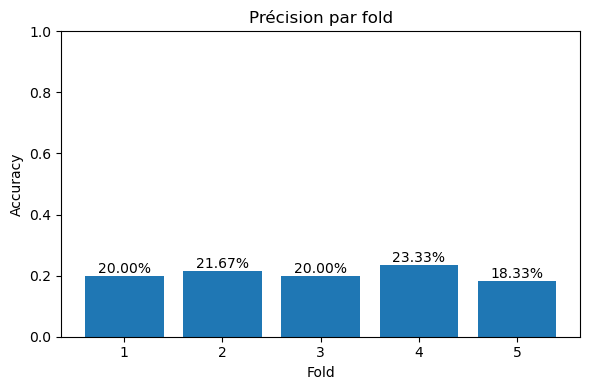

Précision moyenne : 0.207 ± 0.017


In [77]:
# results : liste des précisions que vous avez remplie pendant la CV
folds = np.arange(1, len(results) + 1)

plt.figure(figsize=(6, 4))
plt.bar(folds, results)
plt.ylim(0, 1)
plt.title("Précision par fold")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
for x, y in zip(folds, results):
    plt.text(x, y + 0.01, f"{y:.2%}", ha='center')  # affiche la valeur au-dessus de chaque barre
plt.tight_layout()
plt.show()

print(f"Précision moyenne : {np.mean(results):.3f} ± {np.std(results):.3f}")


## Evaluate model on test set

**TODO**: when you've selected a final model, evaluate its performances (f-score, confusion matrix, ...) on your test set

In [79]:
# ---------------- Paramètres communs ----------------------------------------
initial_epochs = 10
fine_epochs    = 10
seeds          = [0, 1, 2]
models_paths   = []
models         = []

for seed in seeds:
    print(f"\n🔄  Entraînement du modèle seed={seed}")
    tf.keras.utils.set_random_seed(seed)

    model = get_model(num_classes=len(class_names))

    # --- Callbacks : on sauvegarde au format natif Keras --------------------
    ckpt_path = f"best_model_seed{seed}.keras"          # ← extension .keras
    ckpt = tf.keras.callbacks.ModelCheckpoint(
        ckpt_path,
        monitor="val_acc",
        mode="max",
        save_best_only=True,
        verbose=0
    )
    es = tf.keras.callbacks.EarlyStopping(patience=8,
                                          restore_best_weights=True,
                                          verbose=0)
    lr_sched = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_acc",
                                                    factor=0.5,
                                                    patience=2,
                                                    verbose=0,
                                                    min_lr=1e-6)

    # -------- 1) Feature-extraction ----------------------------------------
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss=SparseCategoricalCrossentropy(),
                  metrics=['acc'])

    hist_feat = model.fit(train_ds,
                          epochs=initial_epochs,
                          validation_data=val_ds,
                          callbacks=[ckpt, es, lr_sched],
                          verbose=0)

    # -------- 2) Fine-tuning progressif ------------------------------------
    base_model = model.get_layer('mobilenetv2_1.00_224')
    base_model.trainable = True
    for layer in base_model.layers[:-60]:
        layer.trainable = False

    model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                  loss=SparseCategoricalCrossentropy(),
                  metrics=['acc'])

    _ = model.fit(train_ds,
                  epochs=initial_epochs + fine_epochs,
                  initial_epoch=hist_feat.epoch[-1] + 1,
                  validation_data=val_ds,
                  callbacks=[ckpt, es, lr_sched],
                  verbose=0)

    models_paths.append(ckpt_path)

# ---------------- Chargement des meilleurs poids ----------------------------
for path in models_paths:
    m = tf.keras.models.load_model(path, compile=False)   # format natif
    m.compile(optimizer="adam",
              loss=SparseCategoricalCrossentropy(),
              metrics=['acc'])
    models.append(m)



🔄  Entraînement du modèle seed=0

🔄  Entraînement du modèle seed=1

🔄  Entraînement du modèle seed=2


### Display some misclassified images

**TODO**: display some misclassified images to be able to see what images are difficult for the model

Found 300 files belonging to 5 classes.
246 images mal classées


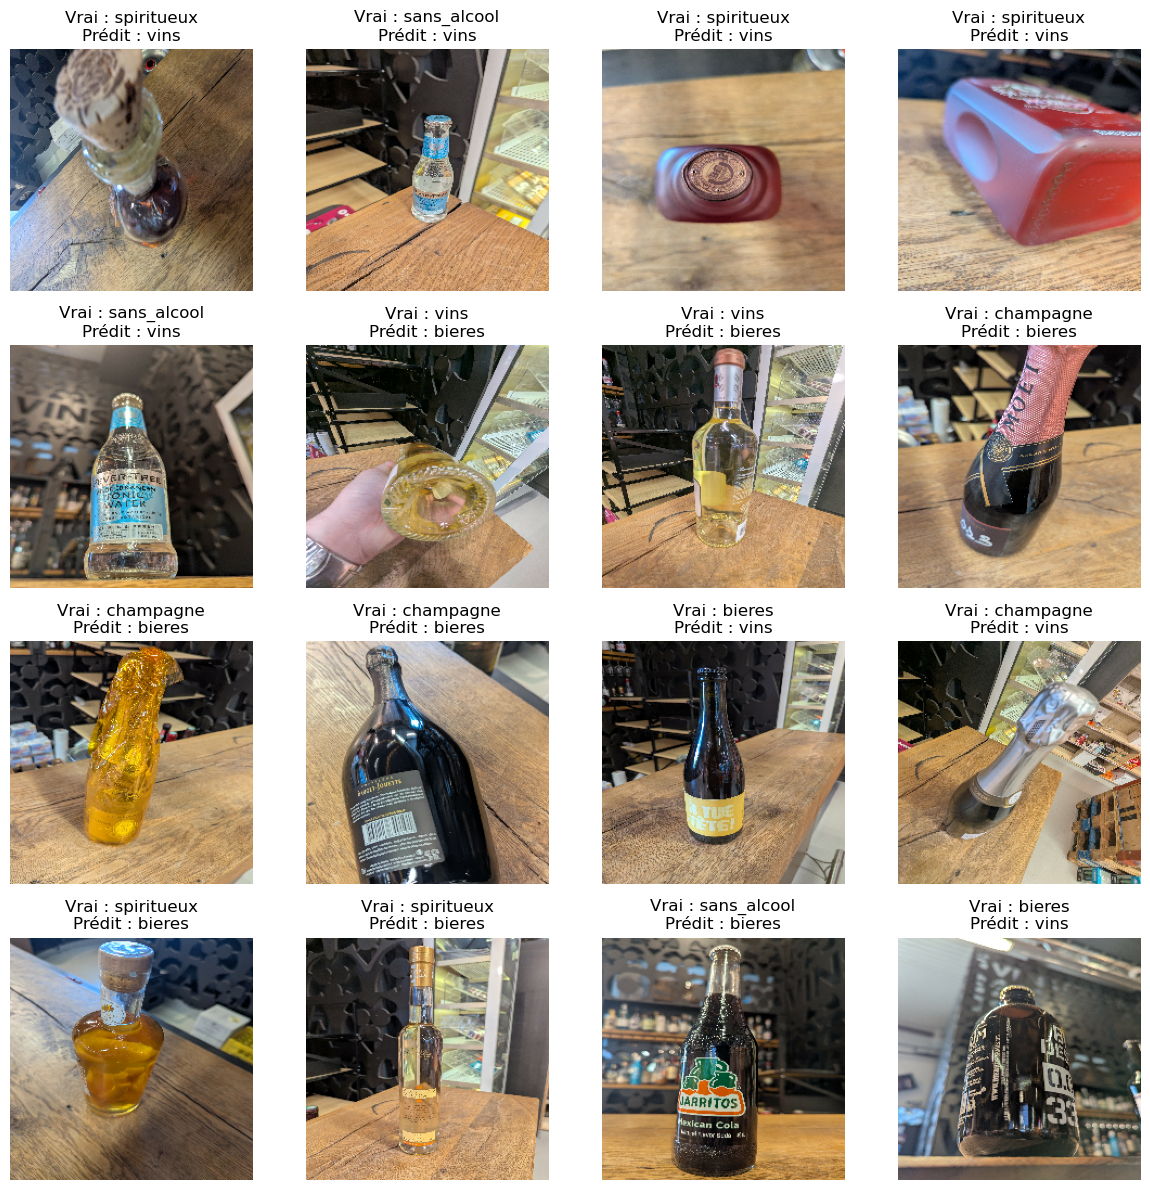

In [81]:
# Récupération des images d'origine (non pré-traitées) + vrais labels
orig_images, y_true_full = [], []
for batch_x, batch_y in tf.keras.preprocessing.image_dataset_from_directory(
        dataset_path,
        image_size=img_size,
        batch_size=1,
        shuffle=False):
    orig_images.append(batch_x[0].numpy().astype("uint8"))
    y_true_full.append(batch_y[0].numpy())
orig_images = np.array(orig_images)
y_true_full = np.array(y_true_full)

# Prédictions
# Prédictions par moyenne des 3 modèles de l’ensemble
imgs_preproc = preprocess_input(orig_images.copy())

probs_stack = [m.predict(imgs_preproc, batch_size=batch_size, verbose=0)
               for m in models]                 # ← modèles déjà chargés
y_prob_full = np.mean(np.stack(probs_stack, axis=0), axis=0)
y_pred_full = np.argmax(y_prob_full, axis=1)

# Indices des erreurs
mis_idx = np.where(y_true_full != y_pred_full)[0]
print(f"{len(mis_idx)} images mal classées")

# Affichage
k = min(16, len(mis_idx))
sample_idx = np.random.choice(mis_idx, k, replace=False)
plt.figure(figsize=(12, 12))
for i, idx in enumerate(sample_idx):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(orig_images[idx])
    plt.title(f"Vrai : {class_names[y_true_full[idx]]}\nPrédit : {class_names[y_pred_full[idx]]}")
    plt.axis("off")
plt.tight_layout()
plt.show()


## Use grad-cam to inspect how the model classify
Here we can see an heatmap of the regions that activates the model the most.

### For more information:
- tf-keras-vis documentation: https://keisen.github.io/tf-keras-vis-docs/
- Grad-cam paper: https://arxiv.org/pdf/1610.02391.pdf
- Grad-cam++ paper: https://arxiv.org/pdf/1710.11063.pdf

**NOTE**: maybe you will need to adapt some variable names based on your code above. For example, _model_ should be the model trained on all the training data. 

ValueError: Input 0 of layer "functional_45" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(1, 4080, 3072, 3)

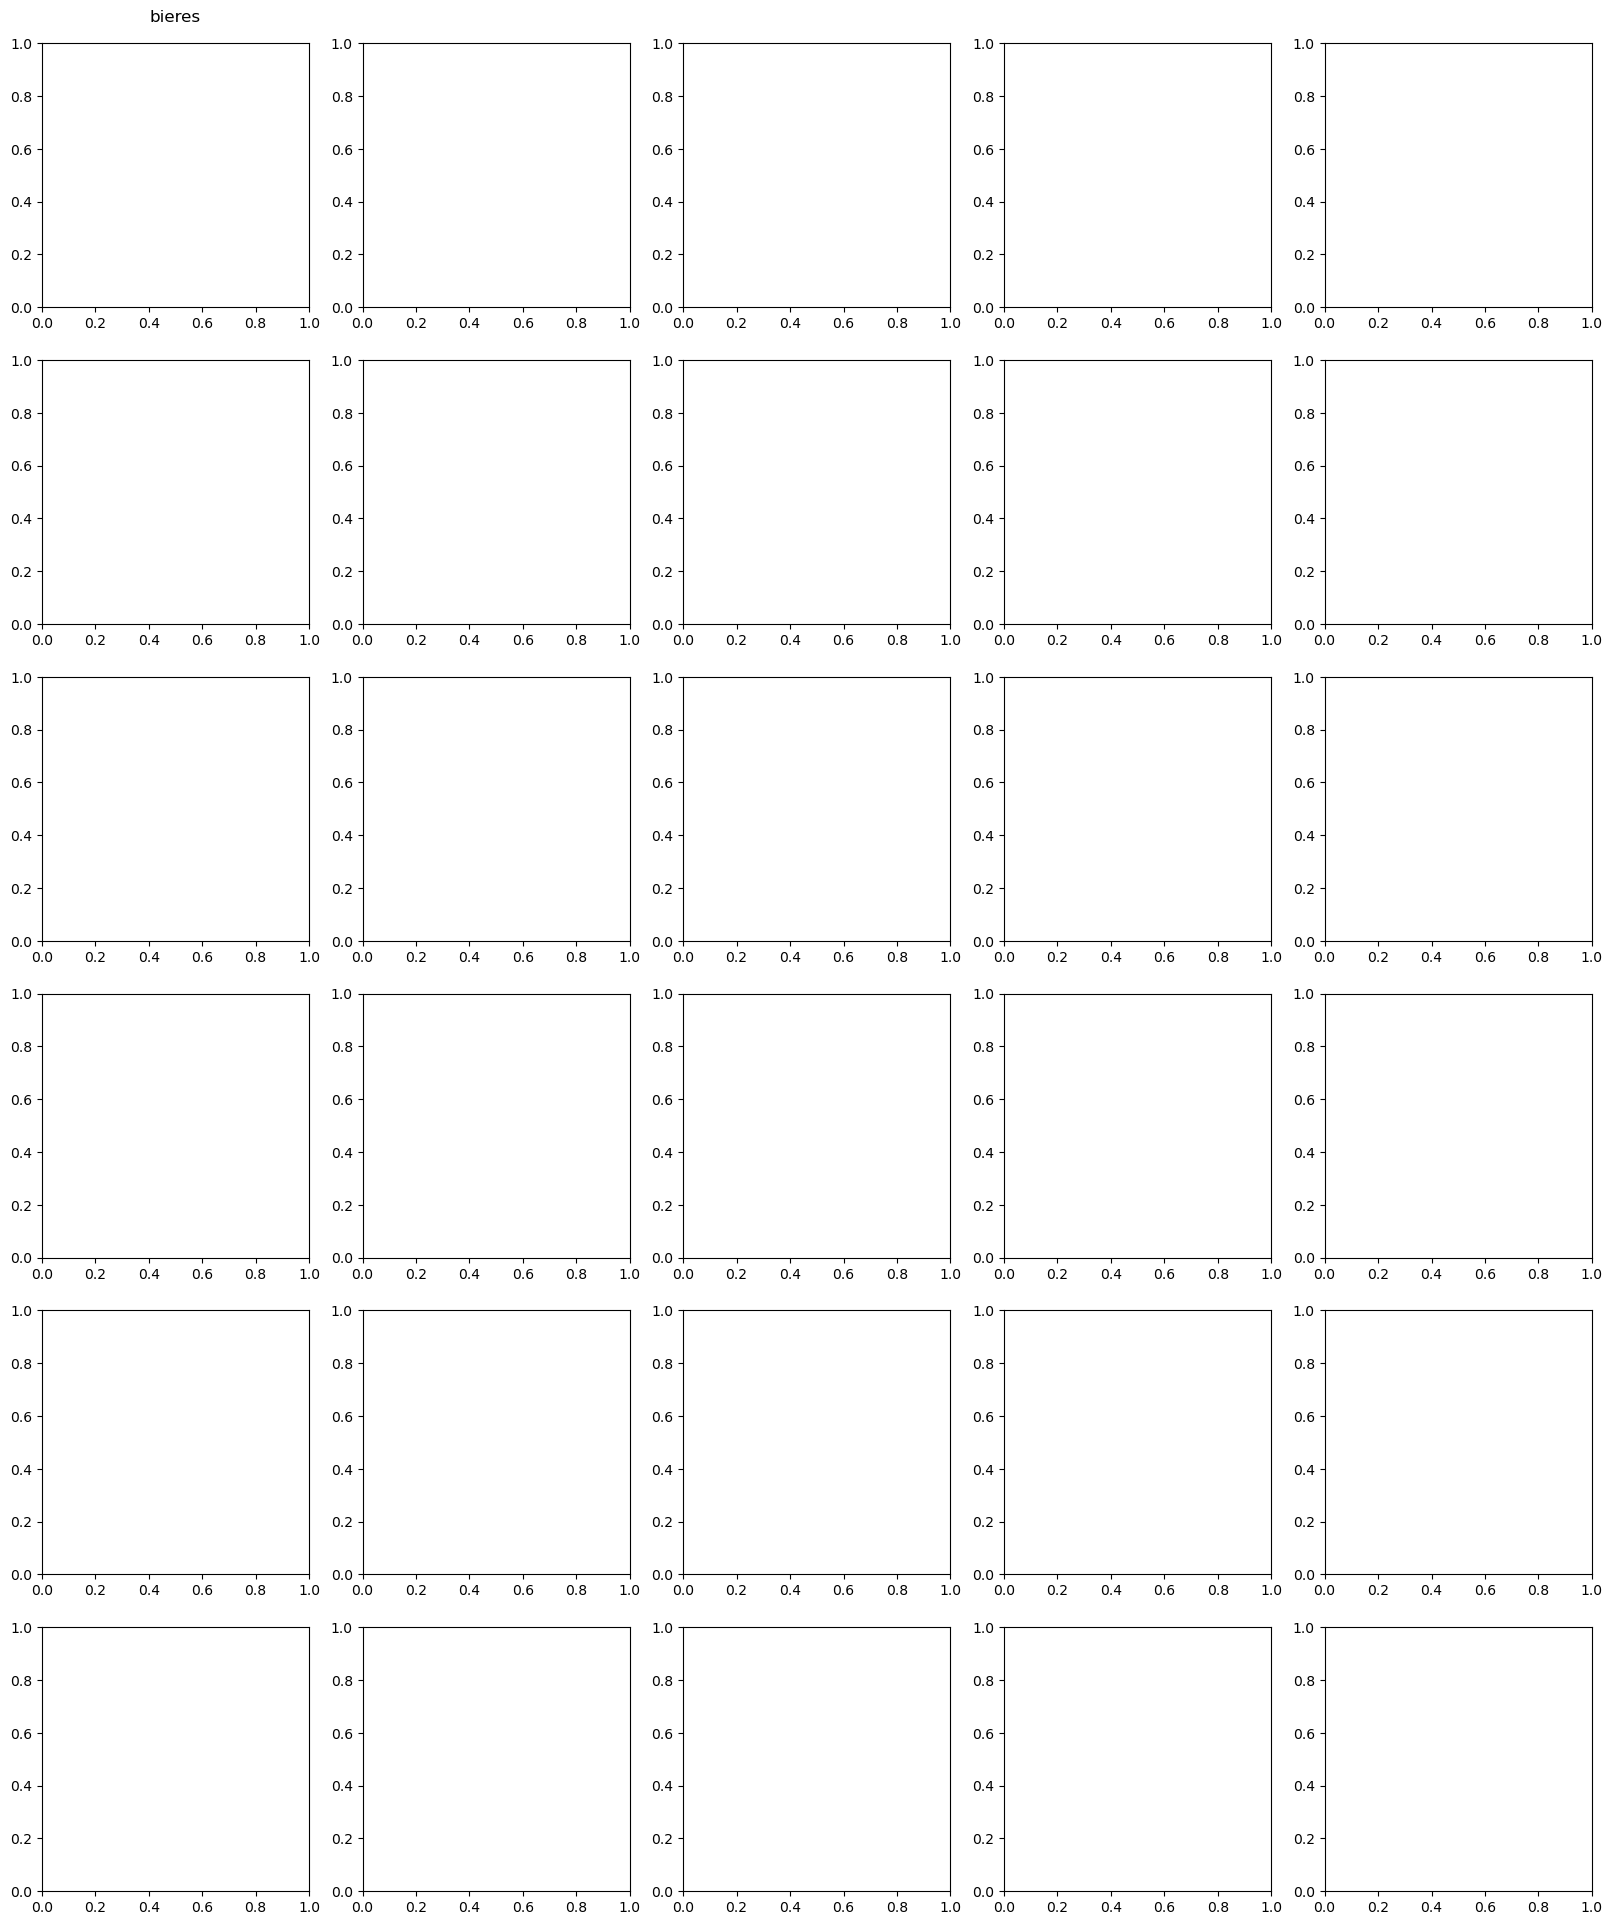

In [93]:
# ------------------------------------------------------------------ #
#  1) Sous-modèle = MobileNetV2 nu (sans vos couches d'augmentation) #
# ------------------------------------------------------------------ #
full_model = models[0]                            # réseau entraîné
mnet       = full_model.get_layer('mobilenetv2_1.00_224')

penultimate_layer = 'block_16_project'            # dernière conv
cam_model = tf.keras.Model(
    inputs=mnet.input,                            # entrée du backbone
    outputs=[                                     # ↖️ deux sorties
        full_model.output,                        # softmax final
        mnet.get_layer(penultimate_layer).output  # feature-map choisie
    ]
)

# ------------------------------------------------------------------ #
#  2) Objet Grad-CAM++                                               #
# ------------------------------------------------------------------ #
gradcam = GradcamPlusPlus(
    cam_model,
    model_modifier=ReplaceToLinear(),             # ReLU → Linéaire
    clone=False                                   # le sous-modèle suffit
)

# ------------------------------------------------------------------ #
#  3) Affichage – on PRE-TRAITE l’image à la main                    #
# ------------------------------------------------------------------ #
nb_images_per_class = 6
fig, axs = plt.subplots(nb_images_per_class, len(class_names),
                        figsize=(len(class_names)*4,
                                 nb_images_per_class*4))

for col, label in enumerate(class_names):
    axs[0, col].set_title(label, y=1.05)

    subset = (train_df[train_df.label == label]
              .sample(nb_images_per_class, random_state=seed))

    for row, (_, rowdata) in enumerate(subset.iterrows()):
        # --- image brute -> float32 0-255
        img_rgb = Image.open(rowdata.path).convert('RGB')
        img_arr = np.array(img_rgb, dtype=np.float32)

        # --- même pré-traitement que MobileNetV2
        img_pre = tf.keras.applications.mobilenet_v2.preprocess_input(img_arr)

        # --- prédiction & classe cible
        pred_logits, _ = cam_model.predict(img_pre[None], verbose=0)
        pred_idx       = int(np.argmax(pred_logits, axis=1))

        # --- carte Grad-CAM++
        cam = gradcam(CategoricalScore(pred_idx),
                      img_pre,                        # <- input
                      penultimate_layer=penultimate_layer)[0]
        heatmap = np.uint8(cm.jet(cam)[..., :3] * 255)

        axs[row, col].imshow(img_rgb)
        axs[row, col].imshow(heatmap, alpha=0.5)
        axs[row, col].axis('off')

plt.tight_layout();  plt.show()


### Grad-cam on misclassified images

**TODO**: now do the same than above, but with the misclassified images. You shouldn't change anything pertaining to grad-cam besides on which image and prediction you do it

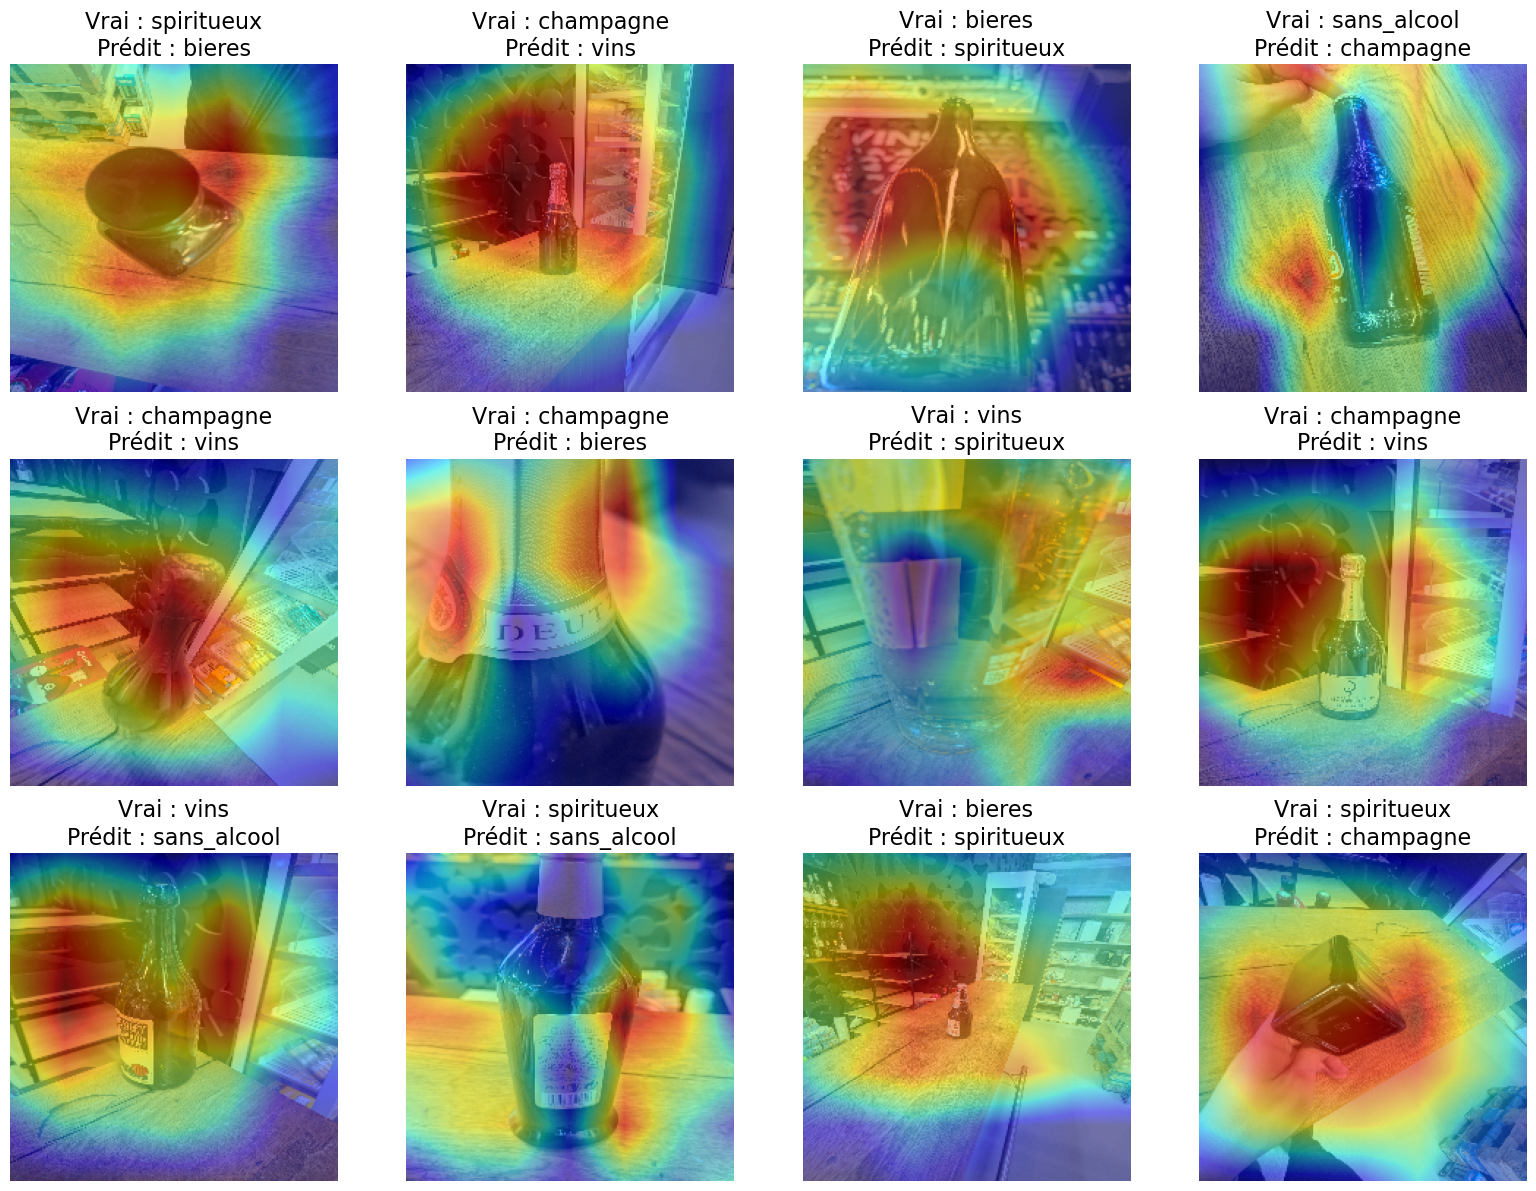

In [35]:
# Grad-CAM sur k images mal classées, affichage 4 par ligne
k = 12                                   # nombre d’images à afficher
sample_idx = np.random.choice(mis_idx, k, replace=False)

n_cols = 4
n_rows = int(np.ceil(k / n_cols))
fig, axs = plt.subplots(n_rows, n_cols,
                        figsize=(n_cols * 4, n_rows * 4))

for pos, idx in enumerate(sample_idx):
    r, c = divmod(pos, n_cols)
    ax   = axs[r, c]
    
    img   = orig_images[idx] / 255.0
    score = CategoricalScore(y_pred_full[idx])
    cam   = gradcam(score, img)[0]
    heat  = np.uint8(cm.jet(cam)[..., :3] * 255)
    
    ax.imshow(img)
    ax.imshow(heat, alpha=0.5)
    ax.set_title(f"Vrai : {class_names[y_true_full[idx]]}\nPrédit : {class_names[y_pred_full[idx]]}",
                 fontsize=16)
    ax.axis("off")

# Masque les cases vides éventuelles
for rem in range(pos + 1, n_rows * n_cols):
    fig.axes[rem].axis("off")

plt.tight_layout()
plt.show()


**TODO**: try to determine what caused the misclassifcations and what you can do about it

Analyse des erreurs de classification et pistes d’amélioration
Constats à partir des Grad-CAM

L’attention du réseau se porte souvent sur l’arrière-plan (table, billets, étagères) plutôt que sur la bouteille ou son étiquette ; il manque donc un signal visuel distinctif.

Les classes champagne, vins et spiritueux partagent des formes/couleurs proches (verre transparent + liquide ambré), ce qui provoque des confusions systématiques.

Quelques photos sont floues, mal cadrées ou sous-exposées : la zone pertinente est petite ou occulte ; le modèle n’apprend pas les bons motifs.

Le modèle n’a été entraîné que sur les couches de tête ; les poids ImageNet restent gelés et peu adaptés à notre domaine.

Actions possibles

Collecte / équilibrage du dataset

Ajouter plus d’images par classe (étiquettes visibles, angles variés).

Veiller à équilibrer les effectifs pour réduire le biais vers les classes majoritaires.

Nettoyage & pré-traitement

Recadrer manuellement ou automatiquement autour de la bouteille (segmentation ou détection d’objet).

Retirer les images floues, trop sombres ou avec arrière-plan dominant.

Augmentations ciblées

Ajouter RandomBrightnessContrast, RandomCrop ou RandomHue pour rendre le modèle moins sensible à l’éclairage et plus concentré sur la forme.

Utiliser RandomRotation(0.2) et RandomZoom(0.2) pour mieux couvrir les variations d’angle.

Fine-tuning plus profond

Dégeler progressivement les derniers blocs de MobileNet V2 (par ex. les 3–4 derniers) et ré-entraîner avec un learning rate faible (1e-5).

Envisager un modèle plus petit mais entièrement fine-tuné (EfficientNet-B0).

Pondération de classes / focal loss

Appliquer un class_weight ou une focal loss pour pénaliser davantage les erreurs sur classes minoritaires.

Validation plus stricte

Utiliser un vrai dossier test indépendant (pas issu du même shooting) pour éviter la fuite de données et mieux estimer la généralisation.

Exploration d’indices textuels

Extraire et reconnaître le texte des étiquettes (OCR) puis fusionner avec la vision (multimodalité) pour distinguer champagne/vin.

En appliquant d’abord les étapes 1 → 4 (plus de données propres + fine-tuning partiel), on devrait déjà réduire significativement le taux d’erreur.